#  Import needed libraries

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D, Flatten,MaxPool2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import tensorflow as tf

In [2]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_encoder = OneHotEncoder(handle_unknown='ignore')

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

#  Read Images and Labels

In [4]:
train_dir = 'data/input/arabic-hwr-ai-pro-intake1/train/'
test_dir = 'data/input/arabic-hwr-ai-pro-intake1/test/'

files1,files2 = [],[]

files1.extend(glob.glob(train_dir + '*.' + 'png')) 
files1 = sorted(files1)
train_images = np.array([cv2.imread(file,cv2.IMREAD_GRAYSCALE) for file in files1])

train_labels = np.genfromtxt('data/input/arabic-hwr-ai-pro-intake1/train.csv',delimiter=',',dtype=int,skip_header=1)[:,1]

files2.extend(glob.glob(test_dir + '*.' + 'png'))
files2 = sorted(files2)
test_images = np.array([cv2.imread(file,cv2.IMREAD_GRAYSCALE) for file in files2])
test_labels = np.genfromtxt('data/input/arabic-hwr-ai-pro-intake1/test.csv',delimiter=',',dtype=int,skip_header=1)

train_images = train_images.reshape(-1, 32, 32, 1)
test_images = test_images.reshape(-1, 32, 32, 1)

encoder = OneHotEncoder(sparse_output=False)
train_labels = encoder.fit_transform(train_labels.reshape(-1,1))

train,validation,y_train,y_val = train_test_split(train_images,train_labels, test_size=0.15, random_state=42,shuffle=True)

# MODELING

In [11]:
model = Sequential()

model.add(Conv2D(64,kernel_size=7,input_shape=(32,32,1),padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(128,kernel_size=5,padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=5,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Conv2D(256,kernel_size=3,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256,kernel_size=3,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Conv2D(512,kernel_size=3,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(512,kernel_size=3,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Conv2D(512,kernel_size=3,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(2048))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(28,activation='softmax'))

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

#Define Callbacks
checkpoint = ModelCheckpoint('weights.keras',monitor='val_loss',save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10)
earlystoppingmonitor = EarlyStopping(patience=40)

#Start Training
training = model.fit(train,y_train,epochs = 100,batch_size = 128, validation_data=(validation,y_val),
                     callbacks=[checkpoint,reduce_lr,earlystoppingmonitor])

#Save after last epoch
model.save('PretrainedModel.h5')

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.1246 - loss: 3.5482 - val_accuracy: 0.1756 - val_loss: 5.3337 - learning_rate: 0.0010
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.4736 - loss: 1.5533 - val_accuracy: 0.2426 - val_loss: 5.2247 - learning_rate: 0.0010
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.6839 - loss: 0.9318 - val_accuracy: 0.4454 - val_loss: 2.5551 - learning_rate: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7776 - loss: 0.6379 - val_accuracy: 0.6171 - val_loss: 1.5363 - learning_rate: 0.0010
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.8294 - loss: 0.4942 - val_accuracy: 0.8333 - val_loss: 0.5332 - learning_rate: 0.0010
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8643 - loss: 0.4018 - val_accuracy: 0.8894 - val_loss: 0.3489 - learning_rate: 0.0010
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.8822 - loss: 0.3461 - 

# Evaluate again on test/val data (Test labels not availible)

In [5]:
#Evaluting on both final model and best val model

#1
bestModel = model
print('For the final epoch: ')
print('Training: ')
bestModel.evaluate(train,y_train)
print('Validation:')
bestModel.evaluate(validation,y_val)

#2
bestModel = load_model('weights.keras')
print('\nFor the (Best val) epoch: ')
print('Training: ')
bestModel.evaluate(train,y_train)
print('Validation:')
bestModel.evaluate(validation,y_val)
print('Done!')

NameError: name 'model' is not defined

### Confusion Matrix of Letters (Label/Prediction)

420/420 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step


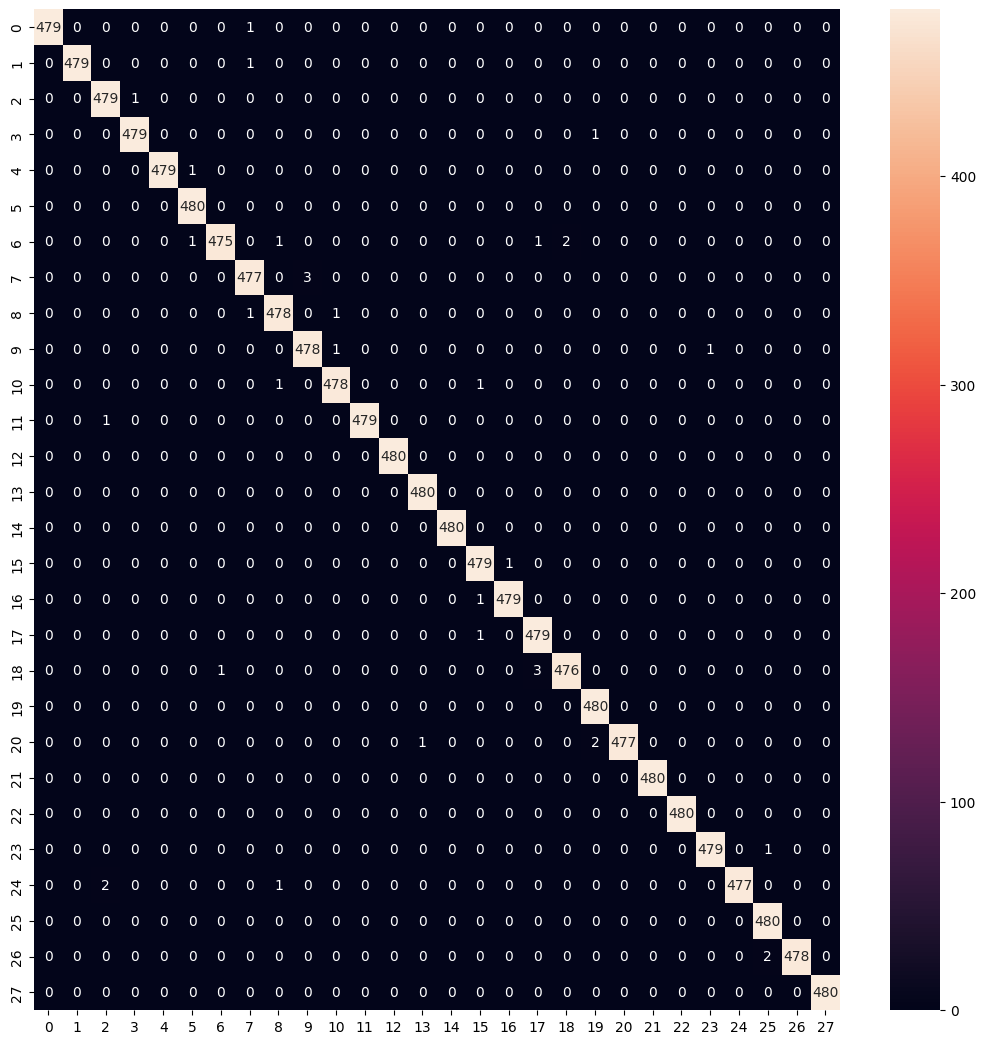

In [13]:
predicitons = model.predict(train_images)
predicitons = np.argmax(predicitons,axis=1)
mat = confusion_matrix(np.argmax(train_labels,axis=1), predicitons)
fig = plt.figure(figsize=(13,13))
sns.heatmap(mat, annot=True, fmt='.3g')
plt.show()

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction:  [18] th letter


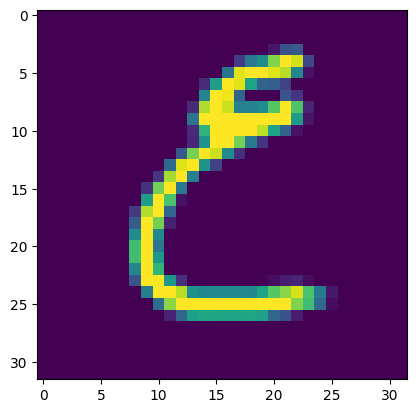

In [18]:
img = load_img('data/input/arabic-hwr-ai-pro-intake1/train/00010.png',color_mode='grayscale')
plt.imshow(img)

p = bestModel.predict(np.expand_dims(img_to_array(img), axis=0))
print('Prediction: ',np.argmax(p,axis=1)+1,'th letter') #(+1) is because model's predection counts from 0 

In [ ]:
# Predict Test Images

# Predict Test Images

In [15]:

testPredections = bestModel.predict(test_images,batch_size = 512)
testPredections = np.argmax(testPredections,axis=1)+1 #(+1) is because model's predection counts from 0 
ids = [i for i in range(0,3360)]
submission_file = pd.DataFrame({'id':ids,'label':testPredections})
pd.DataFrame.to_csv(submission_file,"submission.csv",index=False)
submission_file


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


,id,label
0,0,26
1,1,10
2,2,1
3,3,10
4,4,15
...,...,...
3355,3355,16
3356,3356,6
3357,3357,4
3358,3358,11


NameError: name 'testPredections' is not defined

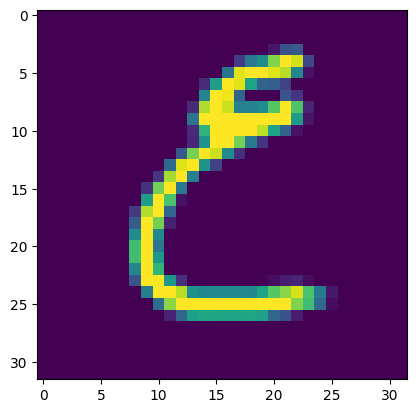

In [6]:
img = load_img('data/input/arabic-hwr-ai-pro-intake1/train/00010.png',color_mode='grayscale')
plt.imshow(img)

p = testPredections[2]
print('Prediction: ',p,'th letter') #(+1) is because model's predection counts from 0 